In [88]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

In [90]:
article_id = 14096681 
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figshareaustralia/"

response = requests.request("GET", url, headers=headers)
data = json.loads(response.text) 
files = data["files"]             
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [5]:
%%time
files_to_dl = ["data.zip"] 
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: total: 12.9 s
Wall time: 58min 36s


In [6]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: total: 44.8 s
Wall time: 45 s


In [12]:
%%sh
ls -ltr figshareaustralia/

total 6016504
-rw-r--r-- 1 plevc 197609 814041183 Mar 28 14:10 data.zip
-rw-r--r-- 1 plevc 197609  95376895 Mar 28 14:10 MPI-ESM-1-2-HAM_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609  94960113 Mar 28 14:10 AWI-ESM-1-1-LR_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609  82474546 Mar 28 14:10 NorESM2-LM_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 127613760 Mar 28 14:10 ACCESS-CM2_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 232118894 Mar 28 14:10 FGOALS-f3-L_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 330360682 Mar 28 14:10 CMCC-CM2-HR4_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 254009247 Mar 28 14:10 MRI-ESM2-0_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 235661418 Mar 28 14:10 GFDL-CM4_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 294260911 Mar 28 14:10 BCC-CSM2-MR_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 295768615 Mar 28 14:10 EC-Earth3-Veg-LR_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 328852379 Mar 28 14:10 CMCC-ESM2_daily_rainfall_NSW.csv

In [10]:
%%time
files = glob.glob('figshareaustralia/*.csv')
files.remove('figshareaustralia\\observed_daily_rainfall_SYD.csv')

df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=file.split('\\')[1].split('_daily')[0])
                for file in files)
              )
df.to_csv("figshareaustralia/combined_data.csv")

CPU times: total: 18min 32s
Wall time: 18min 39s


In [98]:
df = pd.read_csv("figshareaustralia/combined_data.csv")

## High level exploration of data

### 1. Using original format for data

In [136]:
time_start = time()

In [137]:
df.head(3)

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-36.25,-35.00,140.62,142.50,0.00,ACCESS-CM2
1,1889-01-02 12:00:00,-36.25,-35.00,140.62,142.50,0.00,ACCESS-CM2
2,1889-01-03 12:00:00,-36.25,-35.00,140.62,142.50,0.00,ACCESS-CM2


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float64
 2   lat_max        float64
 3   lon_min        float64
 4   lon_max        float64
 5   rain (mm/day)  float64
 6   model          object 
dtypes: float64(5), object(2)
memory usage: 3.3+ GB


In [139]:
pd.set_option("display.precision", 2)
df.describe()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
count,59248543.00,62467843.00,59248543.00,62467843.00,59248543.00
mean,-33.10,-31.98,146.91,148.22,1.90
std,1.96,1.99,3.79,3.81,5.59
min,-36.47,-36.00,140.62,141.25,-0.00
25%,-34.87,-33.66,143.44,145.00,0.00
50%,-33.00,-32.04,146.88,148.12,0.06
75%,-31.40,-30.16,150.19,151.31,1.02
max,-29.90,-27.91,153.75,155.62,432.94


#### Size of original dataframe

In [140]:
df.shape

(62467843, 7)

#### Initial number of models

In [141]:
len(df['model'].unique())

27

#### Number of observations per model

In [ ]:
df['model'].value_counts()

#### Exploring for NaN values

In [142]:
dfna = df[df.isnull().any(axis=1)]
dfna.shape

(3219300, 7)

_As can be seen from the result above, rougly 5% of observations have missing data. That amount is not that large, while exploring proper ways for imputation will take a lot of efforts, so for the first path we will just ignore all those observations with missing values_

In [143]:
df = df.dropna()

#### Number of models after removing NaN values

In [144]:
len(df['model'].unique())

26

_It means that we removed one model completely as it had too many missing values_

#### Size of dataframe without NaN values

In [145]:
df.shape

(59248543, 7)

In [146]:
time_end = time()
simple_eda_time = round(time_end - time_start, 1)
print(f"Time passed {simple_eda_time} seconds")

Time passed 140.6 seconds


<br>

### 2. Reducing memory requirements

In [147]:
df = pd.read_csv("figshareaustralia/combined_data.csv")

In [148]:
dfmem = df.astype({"lat_min": np.float16, "lat_max": np.float16, "lon_min": np.float16, "lon_max": np.float16, "rain (mm/day)": np.float32})

In [149]:
time_start_mem = time()

In [150]:
dfmem.head(3)

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-36.25,-35.00,140.62,142.50,0.00,ACCESS-CM2
1,1889-01-02 12:00:00,-36.25,-35.00,140.62,142.50,0.00,ACCESS-CM2
2,1889-01-03 12:00:00,-36.25,-35.00,140.62,142.50,0.00,ACCESS-CM2


In [151]:
dfmem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float16
 2   lat_max        float16
 3   lon_min        float16
 4   lon_max        float16
 5   rain (mm/day)  float32
 6   model          object 
dtypes: float16(4), float32(1), object(2)
memory usage: 1.6+ GB


In [152]:
pd.set_option("display.precision", 2)
dfmem.describe()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
count,59248543.00,62467843.00,59248543.00,62467843.00,59248543.00
mean,NaN,NaN,NaN,NaN,1.90
std,0.00,0.00,0.00,0.00,5.59
min,-36.47,-36.00,140.62,141.25,-0.00
25%,-34.88,-33.66,143.50,145.00,0.00
50%,-33.00,-32.03,146.88,148.12,0.06
75%,-31.41,-30.16,150.25,151.25,1.02
max,-29.91,-27.91,153.75,155.62,432.94


In [153]:
dfmem.shape

(62467843, 7)

In [154]:
len(dfmem['model'].unique())

27

In [ ]:
dfmem['model'].value_counts()

In [155]:
dfna_mem = dfmem[dfmem.isnull().any(axis=1)]
dfna_mem.shape

(3219300, 7)

In [156]:
dfmem = dfmem.dropna()

In [157]:
len(dfmem['model'].unique())

26

In [158]:
dfmem.shape

(59248543, 7)

In [159]:
time_end_mem = time()
simple_eda_time_mem = round((time_end_mem - time_start_mem), 1)
print(f"Time passed for reduced memory dataframe {simple_eda_time_mem} seconds")

Time passed for reduced memory dataframe 162.3 seconds


## Exploring spatial patterns

_Remove all unnecessary columns during exploration of longitude and lattitude parameters of each model_

In [160]:
dfp = df[['lat_min', 'lat_max', 'lon_min', 'lon_max', 'model']].drop_duplicates()
dfp.head(2)

,lat_min,lat_max,lon_min,lon_max,model
0,-36.25,-35.00,140.62,142.50,ACCESS-CM2
46020,-36.25,-35.00,142.50,144.38,ACCESS-CM2


In [161]:
dfp.shape

(1358, 5)

_It means that for exploration of grid patterns in different models we reduced our original huge dataframe to a tiny dataframe with 1288 row only_

#### Grouping by minimum and maximum values

In [162]:
dfmin = (dfp.groupby(by = "model")
         .min()
         .reset_index()
         .drop(columns=['lat_max', 'lon_max'])
        )
dfmax = (dfp.groupby(by = "model")
         .max()
         .reset_index()
         .drop(columns=['lat_min', 'lon_min'])
        )
dfg = dfmin.merge(dfmax, on="model")
dfg.head(3)

,model,lat_min,lon_min,lat_max,lon_max
0,ACCESS-CM2,-36.25,140.62,-28.75,153.75
1,ACCESS-ESM1-5,-35.62,141.56,-29.38,154.69
2,AWI-ESM-1-1-LR,-35.44,141.56,-29.84,154.69


<br>

#### Comparison of latitude and longitude ranges by model

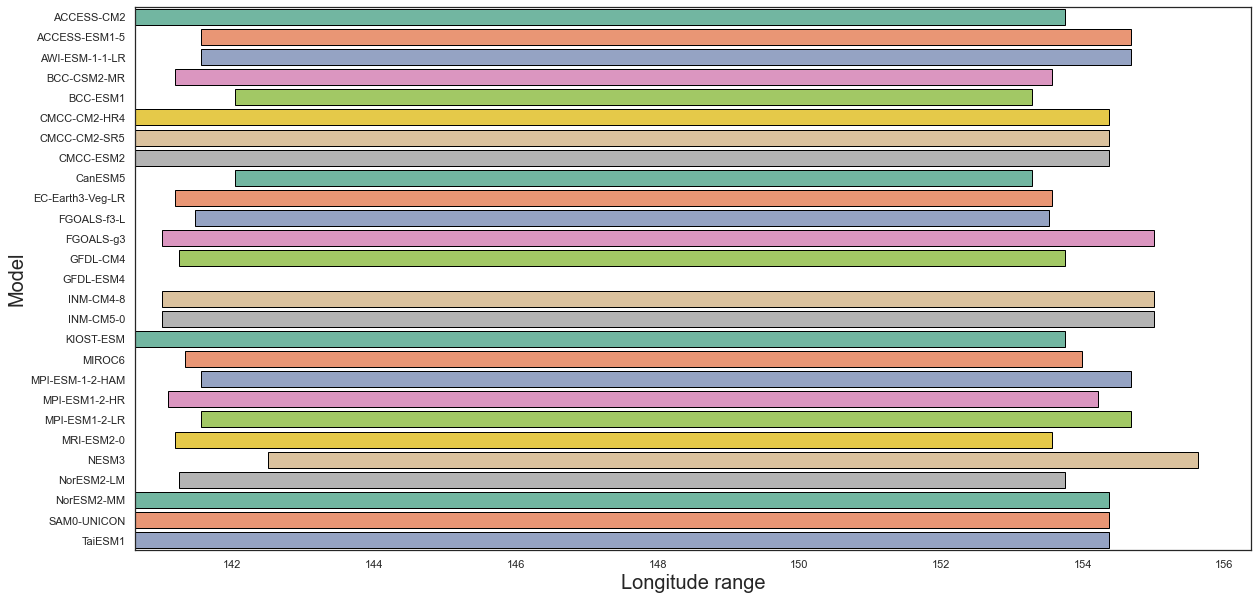

In [163]:
sns.set(rc={'figure.figsize':(20,10),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
ax = sns.barplot(x=dfg['lon_max']-dfg['lon_min'], 
                 y=dfg["model"].unique(), 
                 left=dfg['lon_min'],
                 palette="Set2", 
                 ec='black')
ax.set_xlabel('Longitude range') 
ax.set_ylabel('Model');

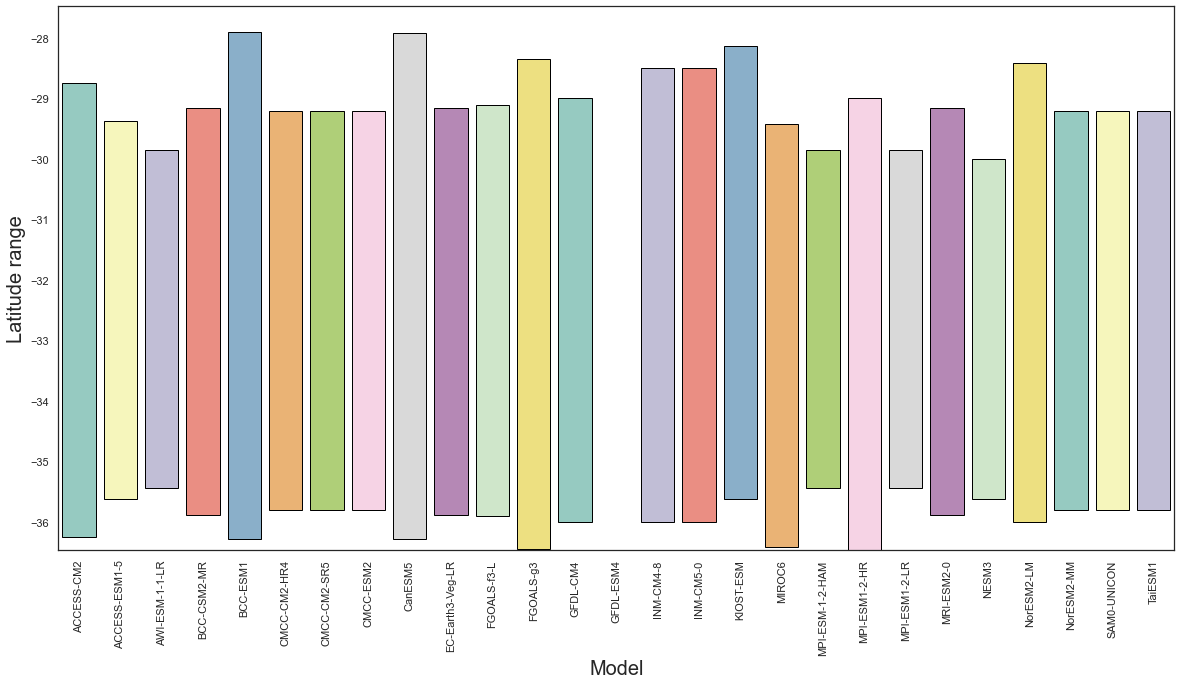

In [164]:
sns.set(rc={'figure.figsize':(20,10),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
ax = sns.barplot(x=dfg["model"].unique(), 
                 y=dfg['lat_max']-dfg['lat_min'], 
                 bottom=dfg['lat_min'],
                 palette='Set3', 
                 ec='black')
ax.set_xlabel('Model') 
ax.set_ylabel('Latitude range')
plt.xticks(rotation=90);

<br>

#### Exploring grid patterns by model

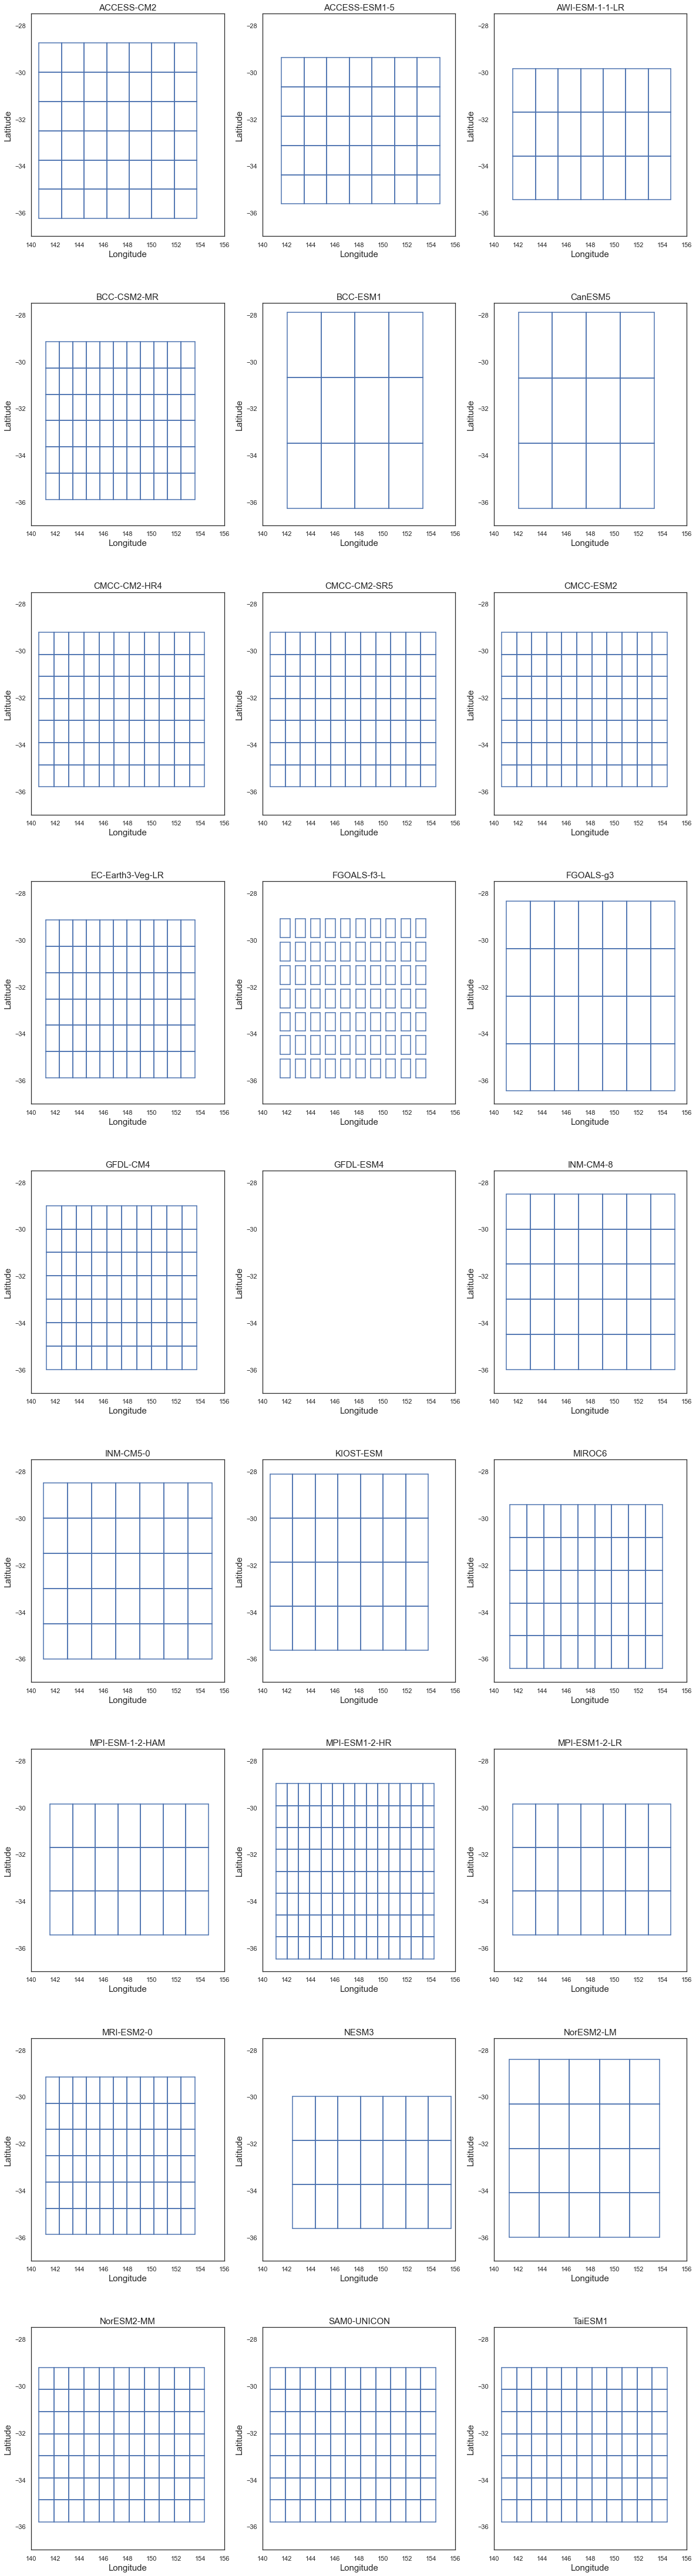

In [165]:
sns.set(rc={'figure.figsize':(20,40),"font.size":15,"axes.titlesize":15,"axes.labelsize":15},style="white") 

models = dfp["model"].unique()
num_models = len(models)

fig = plt.figure()
plt.subplots_adjust(left=None, bottom=0.5, right=None, top=2, wspace=None, hspace=0.3)
for m in range(num_models):
    model = models[m]
    plt.subplot(9, 3, m+1)
    
    dfmod = dfp[dfp['model']==model]
    for i in range(dfmod.shape[0]):
        plt.plot([dfmod['lon_min'].iloc[i], dfmod['lon_min'].iloc[i]], 
                 [dfmod['lat_min'].iloc[i], dfmod['lat_max'].iloc[i]],
                 'b') 
        plt.plot([dfmod['lon_max'].iloc[i], dfmod['lon_max'].iloc[i]], 
                 [dfmod['lat_min'].iloc[i], dfmod['lat_max'].iloc[i]], 
                'b')
        plt.plot([dfmod['lon_min'].iloc[i], dfmod['lon_max'].iloc[i]],
                 [dfmod['lat_min'].iloc[i], dfmod['lat_min'].iloc[i]], 
                'b')
        plt.plot([dfmod['lon_min'].iloc[i], dfmod['lon_max'].iloc[i]], 
                 [dfmod['lat_max'].iloc[i], dfmod['lat_max'].iloc[i]], 
                'b')
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.xlim(140, 156)
        plt.ylim(-37, -27.5)
        plt.title(model)


 _As we can see grid patterns are different for all models, which would require special feature engineering during further modeling_

<br>

## Exploring distributions for amount of rain

_Based on observations at several models, variable "rain (mm/day)" has a long tail in distribution with a lot of outliers. Plotting that data with violin plots is extremely computationaly intensive, so we will just compare those distribution with boxplots with making prior logarithmic transformation_

In [166]:
df['log_rain'] = np.log1p(df['rain (mm/day)'])

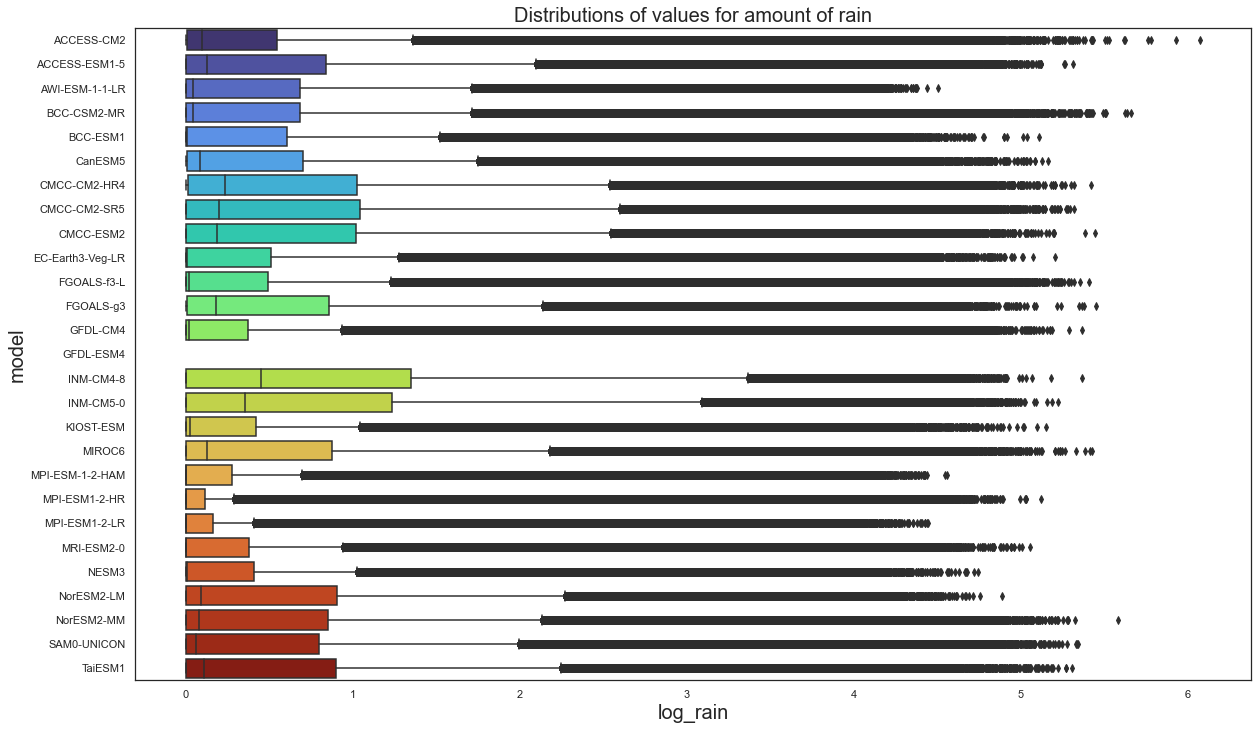

In [167]:
sns.set(rc={'figure.figsize':(20,12),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
sns.boxplot(data = df, x="log_rain", y="model", palette='turbo').set_title('Distributions of values for amount of rain'); 

#### Seasonal distribution of rain amount

_In order to simplify visualisations, we will lump together rain data collected during one of the months. This also alleviates some problem with outliers seen before, making plots more meaningful for comparison_

In [168]:
df['time'] = pd.to_datetime(df['time'])
models = df['model'].unique()
num_models = len(models)

columns = df.columns.to_list()
columns.append('month')
dfm = pd.DataFrame(columns = columns)

for model in df['model'].unique():
    dfmod = df[df['model']==model]
    dfmod = (dfmod.set_index('time')
               .resample('M')
               .mean()
               .reset_index()
               .assign(model = model)
              )
    dfmod['month'] = dfmod['time'].apply(lambda x: x.strftime('%B')) 
    dfm = pd.concat([dfm, dfmod]) 

In [169]:
dfm.shape

(40824, 9)

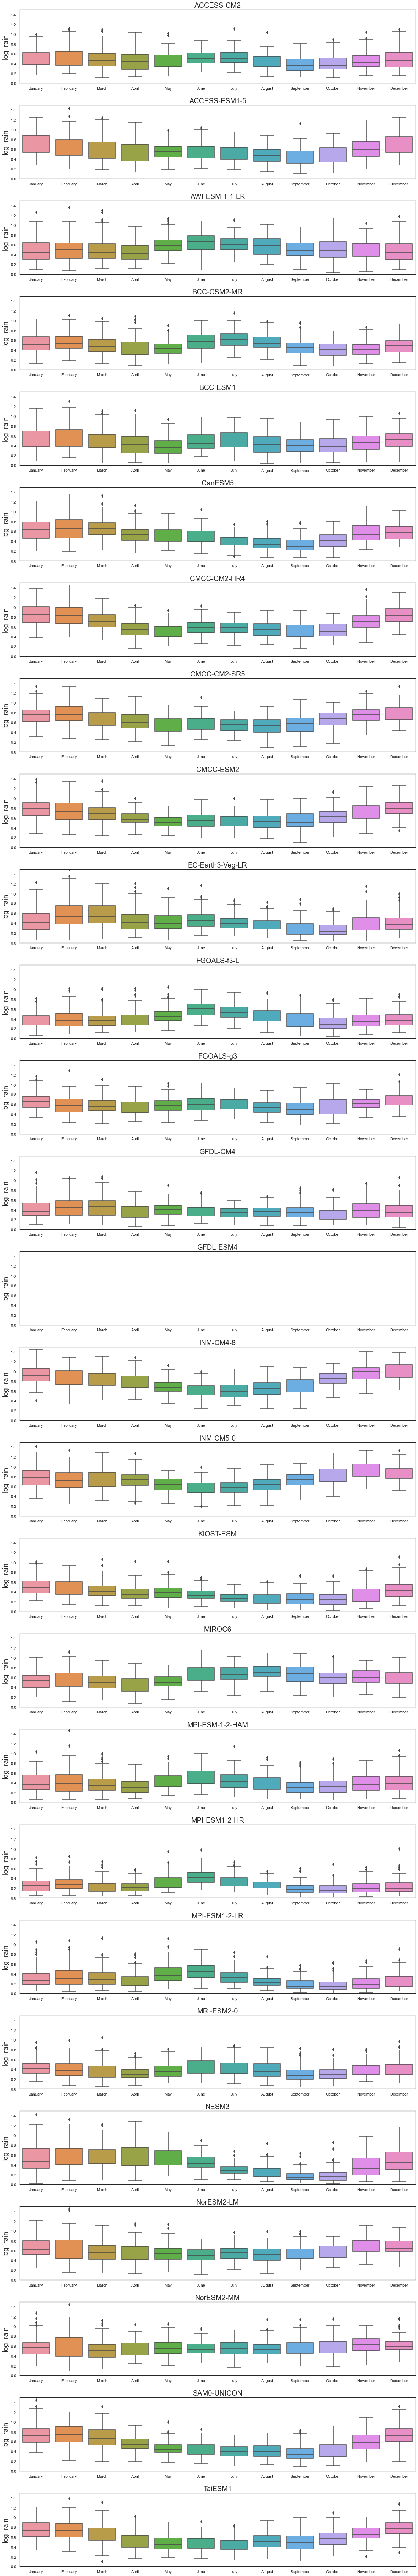

In [170]:
sns.set(rc={'figure.figsize':(20,100),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
fig, axes = plt.subplots(num_models, 1)
plt.subplots_adjust(left=None, bottom=0.5, right=None, top=1.5, wspace=None, hspace=0.3)

for i in range(num_models):
    model = models[i]
    dfmod = dfm[dfm['model']==model]
    sns.boxplot(ax=axes[i], data=dfmod, x="month", y="log_rain").set_title(model) 
    axes[i].set_xlabel("")
    axes[i].set(ylim=(0, 1.5))

<br>

_Same seasonal plots but showing results of different models side by side_

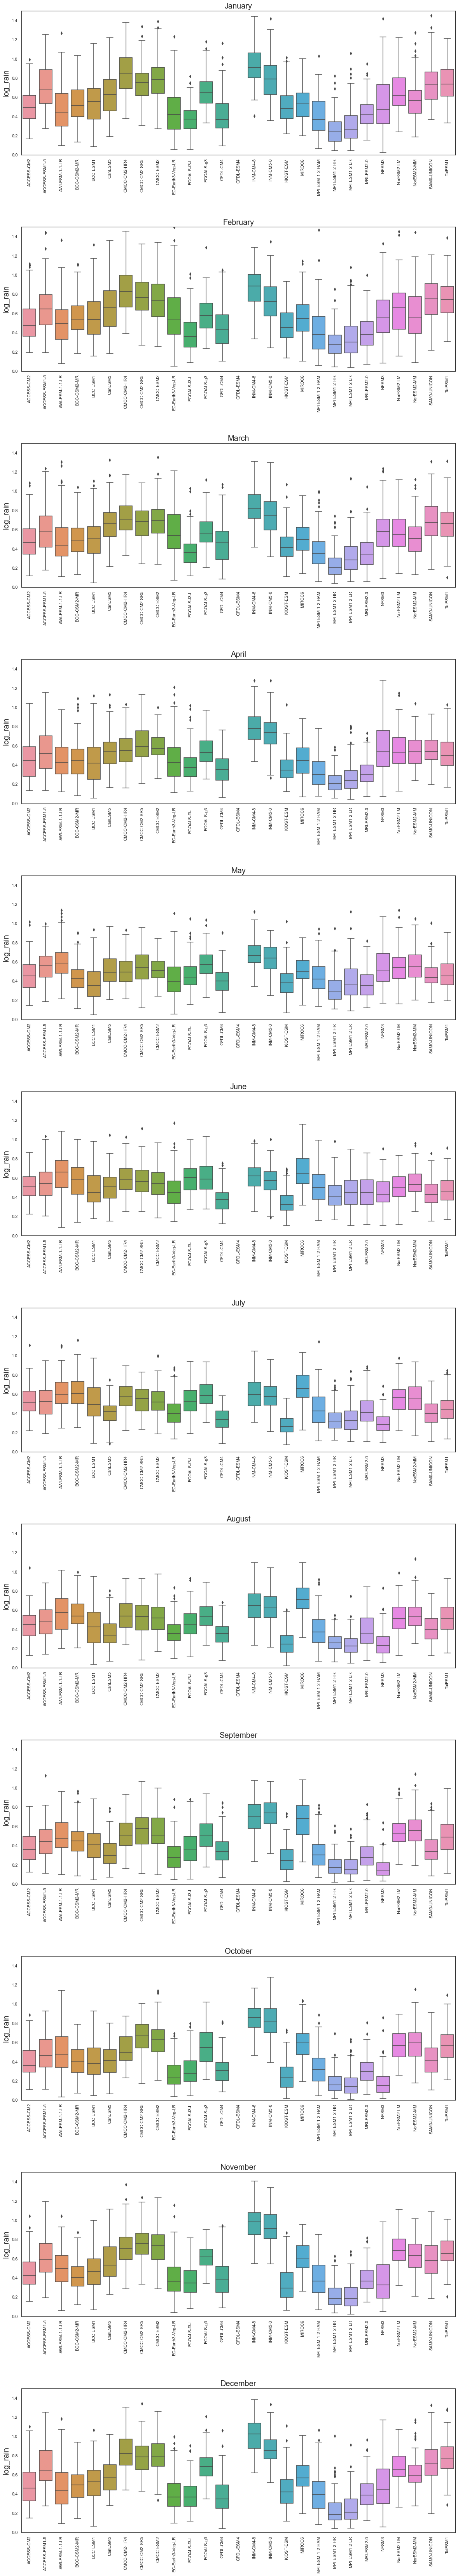

In [171]:
months = list(calendar.month_name)[1:]
num_months = len(months)
sns.set(rc={'figure.figsize':(20,60),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
fig, axes = plt.subplots(num_months, 1)
plt.subplots_adjust(left=None, bottom=0.5, right=None, top=2, wspace=None, hspace=0.5)

for i in range(num_months):
    month = months[i]
    dfmon = dfm[dfm['month']==month]
    sns.boxplot(ax=axes[i], data=dfmon, x="model", y="log_rain").set_title(month) 
    axes[i].set_xlabel("")
    axes[i].set(ylim=(0, 1.5))
    axes[i].tick_params(axis='x', rotation=90);

<br>
<br>

In [183]:
dfm.to_csv("figshareaustralia/monthly_aggregation.csv")

### Converting dataframes to parquet

In [172]:
df.to_parquet("figshareaustralia/combined_data.parquet")
dfm.to_parquet("figshareaustralia/monthly_aggregation.parquet")

<br>
<br>

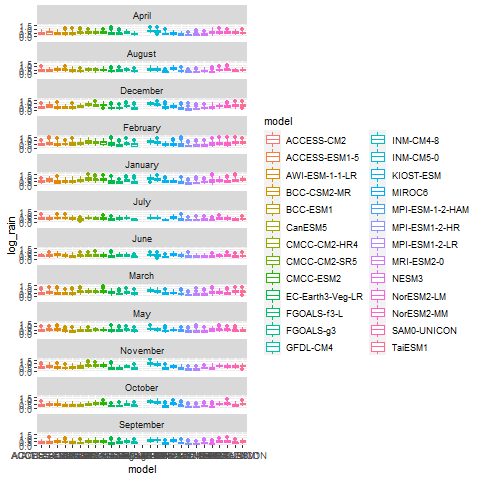

In [209]:
%%R
monthly_plot <-ggplot(dfmr, aes(x=model, y=log_rain, color=model)) +
                  geom_boxplot() +
                  facet_wrap(~month, ncol = 1)       
monthly_plot

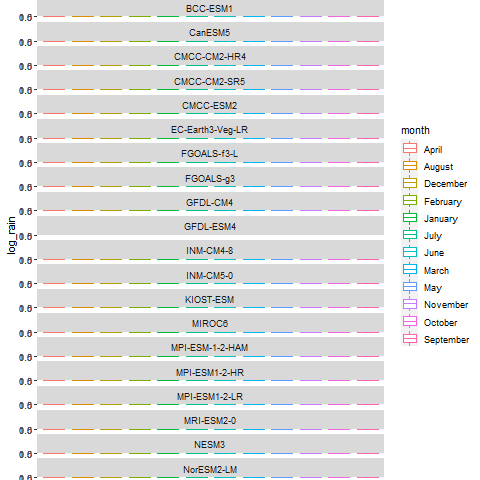

In [206]:
%%R
options(repr.plot.width=20, repr.plot.height=50)
by_model_plot <-ggplot(dfmr, aes(x=month, y=log_rain, color=month)) +
                  geom_boxplot() +
                  facet_wrap(~model, ncol = 1)       
by_model_plot